# Extracting a Time Series

## Introduction

XArray makes it very easy to work with time-series data. The [DataArray](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dataarray) structure provides an efficient way to organize and represent earth observation time-series. We also get the benefit of many time-series processing functiions for temporal interpolation and smoothing. This tutorial shows how we can take individual GeoTIFF files and organize them as a XArray Dataset, extract time-series at any coordinate and do linear interpolation of masked observation.

## Overview of the Task

We will take MODIS Vegetation Indices Version 6.1 data which are generated every 16 days at 250 meter (m) spatial resolution for 2020 year and extract a time-series of Normalised Differnece Vegetation Index (NDVI) and Enhanced Vegetation Index (EVI) at different a point location.

**Input Layers**:
* `modis_vegetation_indices_2020.zip`: A zip file containing GeoTIFF files for MODIS Vegetation Indicies for the state of Karnataka, India.

**Output**:
* `time_series.csv`: A CSV file containing extracted values

**Data Credit**:
*   Didan, K. (2015). MOD13Q1 MODIS/Terra Vegetation Indices 16-Day L3 Global 250m SIN Grid V061. NASA EOSDIS Land Processes DAAC. Accessed 2023-05 from https://doi.org/10.5067/MODIS/MOD13Q1.006




## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install rioxarray

In [47]:
from cycler import cycler
import datetime
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import rioxarray as rxr
import xarray as xr
import zipfile

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [5]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

filename = 'modis_vegetation_indices_2020.zip'
data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'

download(data_url + filename)

Downloaded data/modis_vegetation_indices_2020.zip


## Data Pre-Processing

First we unzip and extract the images to a folder.

In [6]:
zipfile_path = os.path.join(data_folder, filename)
with zipfile.ZipFile(zipfile_path) as zf:
  zf.extractall(data_folder)

We get 3 individual GeoTIFF files per time step.
* `NDVI`: Normalised Differnece Vegetation Index (NDVI) values
* `EVI`: Enhanced Vegetation Index (EVI) values
* `VI_Quality`: Bitmask containing information about cloudy pixels

The information about the image date and measured variable is part of the file name.

For example the file `MOD13A1.006__500m_16_days_NDVI_doy2020161_aid0001.tif` contains **NDVI** values for the Day of the Year (DOY) **161** of the year **2020**.

We will now go through the directory and extract this information to create a XArray DataArray.

In [65]:
def path_to_datetimeindex(filepath):
  filename = os.path.basename(filepath)
  pattern = r'doy(\d+)'
  match = re.search(pattern, filepath)
  if match:
      doy_value = match.group(1)
      timestamp = datetime.datetime.strptime(doy_value, '%Y%j')
      return timestamp
  else:
    print('Could not extract DOY from filename', filename)


timestamps = []
filepaths = []

files = os.path.join(data_folder, 'modis_vegetation_indices_2020', '*.tif')
for filepath in glob.glob(files):
  timestamp = path_to_datetimeindex(filepath)
  filepaths.append(filepath)
  timestamps.append(timestamp)

unique_timestamps = sorted(set(timestamps))

scenes = []

for timestamp in unique_timestamps:
  ndvi_filepattern = r'NDVI_doy{}'.format(timestamp.strftime('%Y%j'))
  evi_filepattern = r'EVI_doy{}'.format(timestamp.strftime('%Y%j'))
  qa_filepattern = r'VI_Quality_doy{}'.format(timestamp.strftime('%Y%j'))
  ndvi_filepath = [
      filepath for filepath in filepaths
      if re.search(ndvi_filepattern, filepath)][0]
  evi_filepath = [
      filepath for filepath in filepaths
      if re.search(evi_filepattern, filepath)][0]
  qa_filepath = [
      filepath for filepath in filepaths
      if re.search(qa_filepattern, filepath)][0]

  ndvi_band = rxr.open_rasterio(ndvi_filepath, chunks={'x':512, 'y':512})
  ndvi_band.name = 'NDVI'
  evi_band = rxr.open_rasterio(evi_filepath, chunks={'x':512, 'y':512})
  evi_band.name = 'EVI'
  qa_band = rxr.open_rasterio(qa_filepath, chunks={'x':512, 'y':512})
  qa_band.name = 'DetailedQA'

  # First 2 bits are MODLAND QA Bits with summary information
  # Extract the value of the 2-bits using bitwise AND operation
  summary_qa = qa_band & 0b11
  qa_band.name = 'SummaryQA'

  # The pixel values of NDVI/EVI files are stored as integers
  # We need to apply the scaling factor to get the actual values as floats
  scale_factor = 0.0001
  scaled_bands = [
      ndvi_band * scale_factor,
      evi_band * scale_factor,
      qa_band,
      summary_qa]
  scene = xr.concat(scaled_bands, dim='band')
  scene = scene.assign_coords(band=['NDVI', 'EVI', 'DetailedQA', 'SummaryQA'])
  scenes.append(scene)

We now have a list of individual XArray Datasets for each time step. We merge them to a single DataSet along the `time` dimension.

In [15]:
time_var = xr.Variable('time', list(unique_timestamps))
time_series_scenes = xr.concat(scenes, dim=time_var)
time_series_scenes

<xarray.DataArray 'NDVI' (time: 22, band: 4, y: 1656, x: 1090)> Size: 1GB
dask.array<concatenate, shape=(22, 4, 1656, 1090), dtype=float64, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 9kB 74.05 74.06 74.06 74.06 ... 78.58 78.59 78.59
  * y            (y) float64 13kB 18.48 18.47 18.47 18.46 ... 11.59 11.59 11.58
    spatial_ref  int64 8B 0
  * band         (band) <U10 160B 'NDVI' 'EVI' 'DetailedQA' 'SummaryQA'
  * time         (time) datetime64[ns] 176B 2020-01-01 2020-01-17 ... 2020-12-18

## Masking Clouds

Before we can extract the time-series, we need to mask cloudy-pixels. We have saved the first 2-bits of the mask in the `SummaryQA` band. The pixel values range from 0-3 and represent the following.

* 0: Good data, use with confidence
* 1: Marginal data, useful but look at detailed QA for more information
* 2: Pixel covered with snow/ice
* 3: Pixel is cloudy

We select all pixels with value 0 or 1 and mask the remaining ones. We can apply this as a vectorized operation across all scenes instead of iterating over each image. This is a very fast and efficient operation enabled by XArray.


In [66]:
summary_qa = time_series_scenes.sel(band='SummaryQA')
time_series_scenes_masked = time_series_scenes \
  .sel(band=['NDVI', 'EVI']) \
  .where(summary_qa <= 1)

Let's preview the result of our cloud masking operation for one of the images

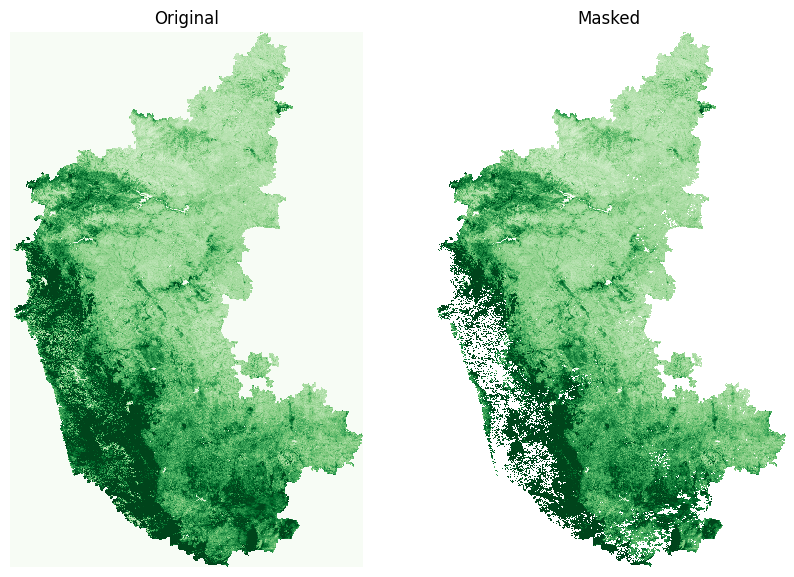

In [38]:
image = time_series_scenes.isel(time=8).squeeze()
masked = time_series_scenes_masked.isel(time=8).squeeze()

fig, (ax0, ax1) = plt.subplots(1,2)
fig.set_size_inches(10,7)


image.sel(band='NDVI').plot.imshow(
    ax=ax0, vmin=0, vmax=0.7, add_colorbar=False, cmap='Greens')
masked.sel(band='NDVI').plot.imshow(
    ax=ax1, vmin=0, vmax=0.7, add_colorbar=False, cmap='Greens')

ax0.set_title('Original')
ax1.set_title('Masked')

for ax in [ax0, ax1]:
    ax.set_axis_off()
    ax.set_aspect('equal')

plt.show()

## Plotting the time-series

We can extract the time-series at a specific X,Y coordinate. As our coordinates may not exactly match the DataArray coords, we use the `interp()` method to get the `nearest` value.

In [45]:
coordinate = (13.16, 77.35) # Lat/Lon
time_series = time_series_scenes_masked \
  .sel(band=['NDVI', 'EVI']) \
  .interp(y=coordinate[0], x=coordinate[1], method='nearest')

Let's plot a time-series chart. We use Matplotlib `cycler` to set custom colors for each line.

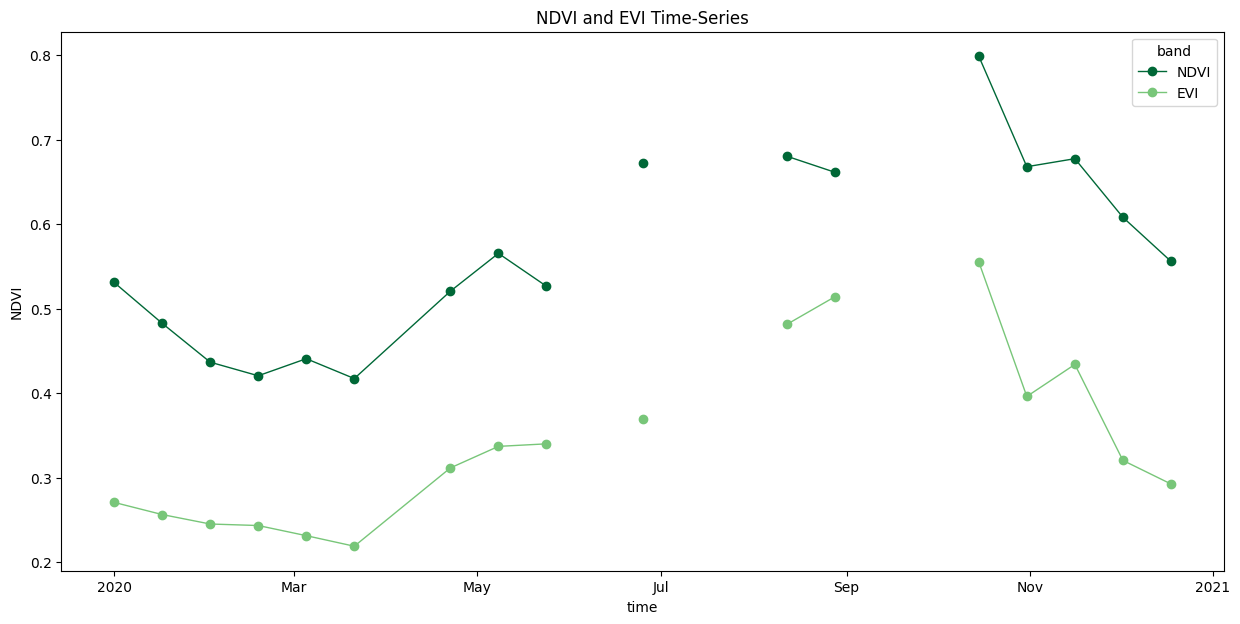

In [51]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

# Select custom colors for NDVI and EVI series
colorlist = ['#006837', '#78c679']
custom_cycler = cycler(color=colorlist)
ax.set_prop_cycle(custom_cycler)
time_series.plot.line(
    ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
ax.set_title('MODIS NDVI and EVI Time-Series')
plt.show()


We have gaps in the time-series due to masked cloudy-pixels. Replace them with linearly interpolated values using XArray's [`interpolate_na()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interpolate_na.html) function.

In [59]:
# As we are proceesing the time-series,
# it needs to be in a single chunk along the time dimension
time_series = time_series.chunk(dict(time=-1))
time_series_interpolated = time_series\
  .interpolate_na(dim='time', method='linear')

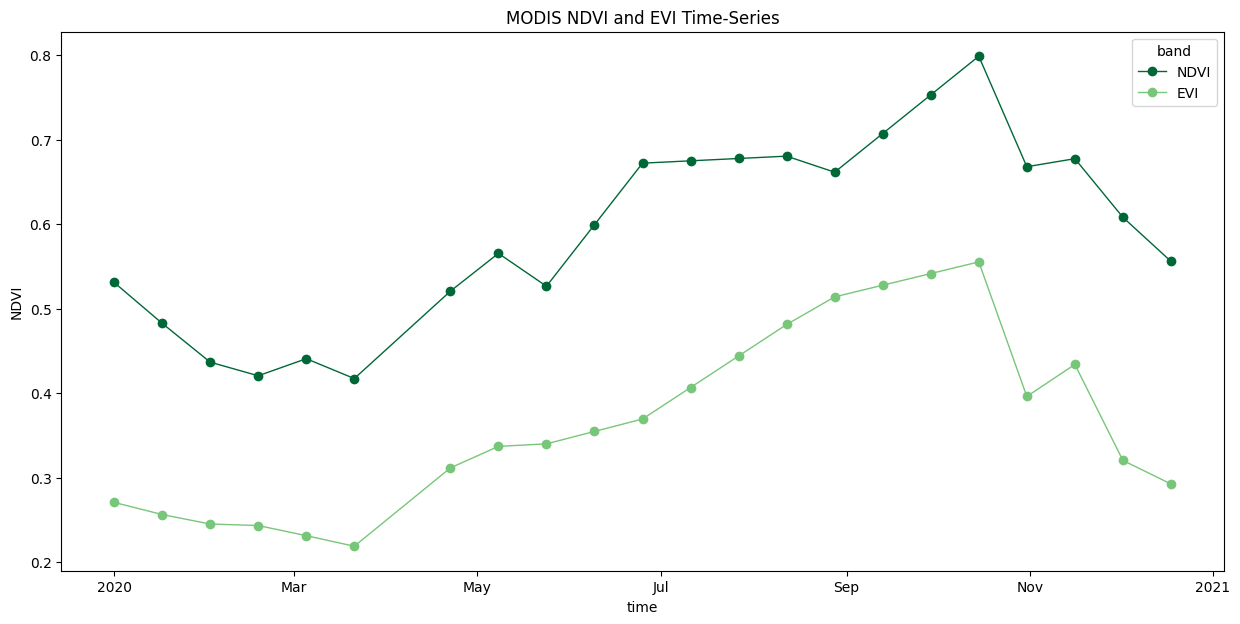

In [60]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

# Select custom colors for NDVI and EVI series
colorlist = ['#006837', '#78c679']
custom_cycler = cycler(color=colorlist)
ax.set_prop_cycle(custom_cycler)
time_series_interpolated.plot.line(
    ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
ax.set_title('MODIS NDVI and EVI Time-Series')
plt.show()

## Saving the Time-Series

Convert the extracted time-series to a Pandas DataFrame.

In [63]:
df = time_series_interpolated.to_pandas().reset_index()
df.head()

band,time,NDVI,EVI
0,2020-01-01,0.5311,0.2707
1,2020-01-17,0.4827,0.2563
2,2020-02-02,0.4367,0.2451
3,2020-02-18,0.4206,0.2433
4,2020-03-05,0.4408,0.2313


Save the DataFrame as a CSV file.

In [64]:
output_filename = 'time_series.csv'
output_filepath = os.path.join(output_folder, output_filename)
df.to_csv(output_filepath, index=False)

----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>